# Data Mining 21/22 Final Project [DEMO VERSION]
Implementation of a Deep Convolutional GAN for generating [Ukiyo-e](https://en.wikipedia.org/wiki/Ukiyo-e)


![img](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/350px-Tsunami_by_hokusai_19th_century.jpg)

# Basic Imports
Using mainly:
- Pytorch
- Numpy
- Tensorflow (for image loading)
- Sklearn (for results)


In [50]:
# Basic Imports
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import pandas as pd

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.utils import make_grid
from torchvision.datasets.folder import default_loader

from PIL import Image

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [52]:
device

'cuda'

# Parameters definition
Choose values for:
  #### Dataset Parameters
- **Batch Size** (loaded from dataset)
- **Image Size** (both 128 or 64, best performances with 64)
- **Normalization Stats**

#### Training Parameters
- **Beta 1** for Adam Optimizator
- **Loss Criterion**
- **Learning Rate**
- **Training Epochs** (at least 200 suggested)

In [53]:
# Dataset Parameters
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Training Paramters
beta1 = 0.5
criterion = F.binary_cross_entropy
lr = 0.0002
epochs = 450

# Data loading 
Using a redefinition of pytorch Dataset class to pre-load images. The dataset used is [The Metropolitan Museum of Art Ukiyoe Dataset](https://www.kaggle.com/kengoichiki/the-metropolitan-museum-of-art-ukiyoe-dataset)

In [54]:
transform_ds = transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

In [55]:
# Custom Ds for npz
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [56]:
data_path = "data.npy"

# Data Augmentation
Necessary for improving generator performances by applying:
- Random Vertical Flip
- Color Jitter
- Random Resize Crop
- Random Posterize
to every image

In [57]:
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [58]:
if not os.path.exists(data_path):
    # Pre-load all data 
    dataset = []
    labels  = []
    count=0
    print("Loading dataset...")
    for file in tqdm(names):
        path=os.path.join(train_dir,file)
        for im in os.listdir(path):
            image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb',target_size=image_size)
            image=img_to_array(image, dtype='uint8')
            
            ## AHUGmentation!
            dataset.append(image)
            image_base = Image.fromarray(image.astype(np.uint8))
            
            image = transforms.RandomVerticalFlip(p=1)(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            image = transforms.ColorJitter(brightness=.2, hue=.0)(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            image = transforms.RandomResizedCrop(size=(64, 64))(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            image = transforms.RandomPosterize(bits=2)(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            # Insert Labels
            for j in range(5):
                labels.append(classes_dict[file])
           
            count+=1

    with open(data_path, 'wb') as f:
        # Save progresses
        np.save(f, np.asarray(dataset))
        np.save(f, np.asarray(labels))
else:
    with open(data_path, 'rb') as f:
        # Load progresses to avoid extra computation
        dataset = list(np.load(f))
        labels  = list(np.load(f))


In [60]:
dataset = np.asarray(dataset)
print(dataset[0].shape)

ds_2 = MyDataset(dataset,labels,transform=transform_ds)
print("Dataset elements number:",len(ds_2))

train_dl = DataLoader(ds_2, batch_size, shuffle=True, num_workers=2, pin_memory=True)

(64, 64, 3)
Dataset elements number: 20090


In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

Min and max pixel values: -0.60784316 1.0
torch.Size([3, 64, 64])


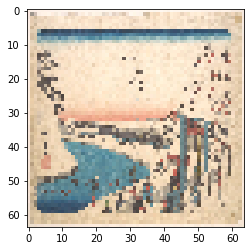

In [78]:
images,label = ds_2[12000]

print("Min and max pixel values:", images.numpy().min(), images.numpy().max())
print(images.size())

plt.imshow(denorm(images).permute(1,2,0))

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

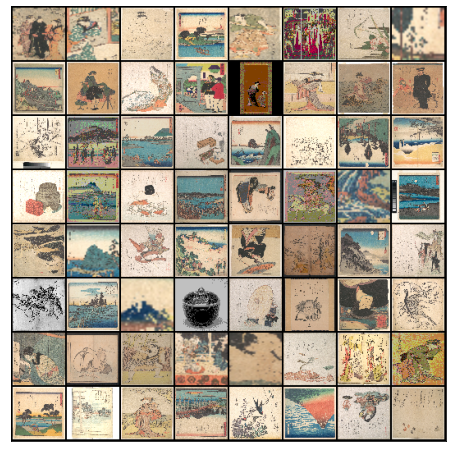

In [83]:
show_batch(train_dl)

In [84]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [85]:
device = get_default_device()
device

device(type='cuda')

In [86]:
train_dl = DeviceDataLoader(train_dl, device)

# Model definition
Deep Convolutional Generative Adversarial Network defined according to [this paper](https://arxiv.org/pdf/1511.06434.pdf%5D)
![img](https://miro.medium.com/max/777/1*rdXKdyfNjorzP10ZA3yNmQ.png)

*Generator model*

## Discriminator

In [87]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #nn.Dropout(p=0.1),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #nn.Dropout(p=0.1),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #nn.Dropout(p=0.1),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #nn.Dropout(p=0.1),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Dropout(p=0.3),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator__128 = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 128, kernel_size=4, stride=4, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Dropout(p=0.3),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [88]:
# Model Summary
from torchsummary import summary

In [89]:
discriminator = to_device(discriminator, device)

summary(discriminator,(3,image_size[0],image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Dropout-14              [-1, 

## Generator

In [90]:
latent_size = 100

In [91]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generator__128 = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(128, 3, kernel_size=8, stride=4, padding=2, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [92]:
generator = to_device(generator, device)

summary(generator,(latent_size,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

torch.Size([128, 3, 64, 64])


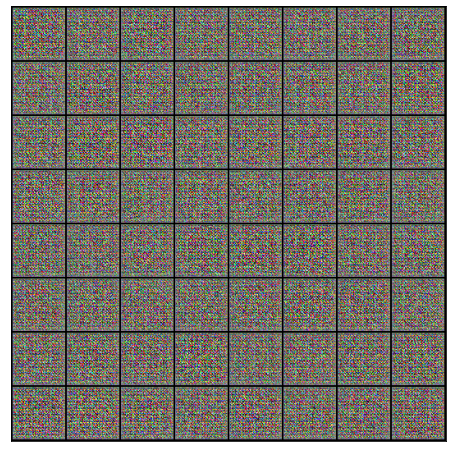

In [93]:
# Quick Test
xb = torch.randn(batch_size, latent_size, 1, 1).to(device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.to("cpu"))

# Load Checkpoints for DCGAN
Loading checkpoints and showing results

In [94]:
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.datasets as dset

In [95]:
import random

In [96]:
if os.path.exists("D.ckpt") and os.path.exists("G.ckpt"):
    checkpoint = torch.load("D.ckpt")
    discriminator.load_state_dict(checkpoint)
    print("successfully loaded Discrimitaor checkpoint")
    checkpoint = torch.load("G.ckpt")
    generator.load_state_dict(checkpoint)
    print("successfully loaded Generator checkpoint")


successfully loaded Discrimitaor checkpoint
successfully loaded Generator checkpoint


In [97]:
from torchvision.utils import save_image

In [98]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [99]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))

In [100]:
from IPython.display import Image as I

# Generate image with loaded data
Images generated with loaded data

In [105]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


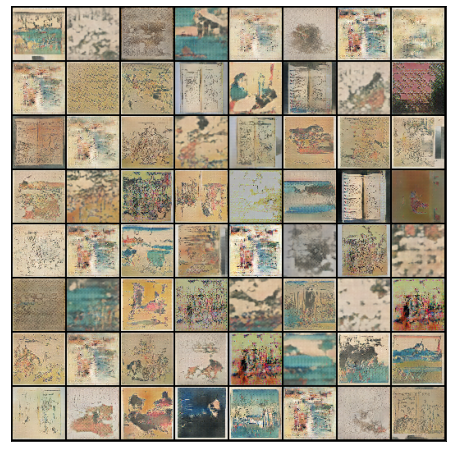

In [106]:
save_samples(0, fixed_latent)

# Conditional GAN (cGAN)
In the second part of the project we will try to model a cGAN according to [this paper](https://arxiv.org/abs/1411.1784) in order to generate Ukiyo-e in the style of the selected author from the dataset

## Parameters
This cGAN works best with 128x128 images, so we reload them

In [107]:
batch_size = 128
image_size = (128,128)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
beta1 = 0.5

image_shape = (3, 128, 128)
image_dim = int(np.prod(image_shape))

n_classes = 50
embedding_dim = 100

In [108]:
data_path = "data_cgan.npy"

In [109]:
if not os.path.exists(data_path):
    # RELOAD all data 
    dataset   = []
    labels    = []
    print("Loading dataset...")
    for file in tqdm(names):
        path=os.path.join(train_dir,file)
        for im in os.listdir(path):
            image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb',target_size=image_size)
            image=img_to_array(image, dtype='uint8')
            
            ## AHUG!
            dataset.append(image)
            image_base = Image.fromarray(image.astype(np.uint8))
            
            image = transforms.RandomVerticalFlip(p=1)(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            image = transforms.ColorJitter(brightness=.2, hue=.0)(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            image = transforms.RandomResizedCrop(size=(128, 128))(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            image = transforms.RandomPosterize(bits=2)(image_base)
            image=img_to_array(image, dtype='uint8')
            dataset.append(image)
            
            for j in range(5):
                labels.append(classes_dict[file])
           
    with open(data_path, 'wb') as f:
        np.save(f, np.asarray(dataset))
        np.save(f, np.asarray(labels))
else:
    with open(data_path, 'rb') as f:
        dataset = list(np.load(f,allow_pickle=True))
        labels  = list(np.load(f,allow_pickle=True))


In [110]:
dataset = np.asarray(dataset,dtype=object)
transform_ds = transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

ds_3 = MyDataset(dataset,labels,transform=transform_ds)
print("Dataset elements number:",len(ds_3))

train_dl_2 = DataLoader(ds_3, batch_size, shuffle=True, num_workers=2, pin_memory=True)

Dataset elements number: 20090


In [111]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# cGAN Model
![img](https://learnopencv.com/wp-content/uploads/2020/12/conditional-gan-tech-arch-516x1024.jpg)

*Shape of the models*

## Discriminator

In [112]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

In [113]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)
summary(discriminator.model,(6,128,128))

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(50, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)

## Generator

In [114]:
latent_dim = 100

In [115]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [116]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)
summary(generator.model,(513,4,4))

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(50, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_s

# Training cGAN

In [117]:
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.datasets as dset

from torchvision.utils import save_image

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

In [118]:
if os.path.exists("discriminator_cgan.ckpt") and os.path.exists("generator_cgan.ckpt"):
    checkpoint = torch.load("discriminator_cgan.ckpt")
    discriminator.load_state_dict(checkpoint)
    print("successfully loaded Discrimitaor checkpoint")
    checkpoint = torch.load("generator_cgan.ckpt")
    generator.load_state_dict(checkpoint)
    print("successfully loaded Generator checkpoint")

successfully loaded Discrimitaor checkpoint
successfully loaded Generator checkpoint


# cGAN Final Results
The final results, despite the correct training of the models, are not very impressive, mainly beacuse the dataset did not offer enough samples per author to have meaningful results in so many different artists styles

In [119]:
device = 'cpu'
discriminator.to(device)
generator.to(device)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(50, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_s

In [123]:
noise_vector = torch.randn(64, latent_dim, device=device)  
noise_vector = noise_vector.to(device)

In [ ]:
# Try to generate 10 image on the syle of #13 author: Hokusai
generated_image = generator((noise_vector, torch.IntTensor(np.full((64),13)).to(device)))
save_image(generated_image.data[:20], 'generated/sample_final.png', nrow=5, normalize=True)

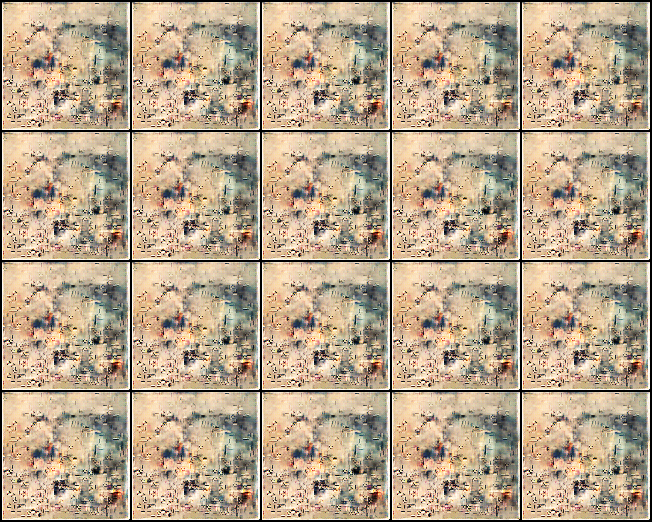

In [127]:
I('./generated/sample_final.png')